# Test Autoencoder + BNN
In this notebook we will test the ability of a BNN to guide the counterfactual exploration for various dimensions.

In [1]:
inDrive = True

if inDrive:
    from google.colab import drive
    drive.mount('/content/drive')
    import os
    import sys
    os.chdir('/content/drive/MyDrive/Hybrid-CLUE/MyImplementation/training_notebooks')

    # Get the parent directory of MyImplementation
    my_implementation_parent = os.path.abspath(os.path.join(os.getcwd(), '..'))

    # Add it to sys.path if not already present
    if my_implementation_parent not in sys.path:
        sys.path.insert(0, my_implementation_parent)

Mounted at /content/drive


## Setup


Import libraries

In [4]:
%pip install torchbnn

In [5]:
import importlib
import sys
# Import our custom modules
from models import FlexibleAutoencoder
from models import BNN_VI

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os

Set the device

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


Load the Datasets

In [7]:
# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

Set the latent dimension

In [ ]:
latent_dim = 256

Create a models directory if it doesn't exist

In [8]:
# Create models directory in parent directory if it doesn't exist
os.makedirs(os.path.join('..', 'model_saves'), exist_ok=True)
model_saves_path = os.path.join('..', 'model_saves')

## Input space optimisation
Let's try to create CLUEs from the input space

We'll start be defining an identify backbone that allows us to just pass the input to the Bayesian layers

In [9]:
import torch
import torch.nn as nn

class IdentityBackbone(nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self, x):
        if len(x.shape) > 2:
            return x.view(x.size(0), -1)
        else:
            return x

    def decode(self, x):
        return x.view(x.size(0), 1, 28, 28)

Next we'll train the bayesian layers on the input space

In [22]:
from models.BNN_VI import BayesianNeuralNetworkVI

# Create the identity backbone
identity_backbone = IdentityBackbone()

# Determine input and output dimensions
input_dim = 784  # For MNIST flattened input (28x28), adjust as needed
output_dim = 10  # Number of classes

# Create the BNN with the identity backbone
bnn_model = BayesianNeuralNetworkVI(
    backbone=identity_backbone,
    input_dim=input_dim,      # This should match your raw input dimension
    output_dim=output_dim,    # Number of classes
    device=device,
    hidden_dim=1024
)

And now we trrain

In [23]:
from train import train_BNN_VI_classification

train_BNN_VI_classification(
    net=bnn_model,
    name='BNN_VI_identity',
    batch_size=64,
    nb_epochs=10,
    trainset=trainset,
    valset=testset,
    device=device,
    model_saves_dir=model_saves_path)


Bayesian Neural Network (VI):
it 0/10, Jtr = 0.018, err = 0.356, KL = 0.032,    time: 4.924726 seconds

    Jdev = 0.297, err = 0.089

best validation error
it 1/10, Jtr = 0.006, err = 0.108, KL = 0.054,    time: 5.197469 seconds

    Jdev = 0.195, err = 0.062

best validation error
it 2/10, Jtr = 0.004, err = 0.074, KL = 0.070,    time: 4.833056 seconds

    Jdev = 0.148, err = 0.045

best validation error
it 3/10, Jtr = 0.003, err = 0.057, KL = 0.086,    time: 4.784400 seconds

    Jdev = 0.114, err = 0.036

best validation error
it 4/10, Jtr = 0.002, err = 0.045, KL = 0.100,    time: 4.802179 seconds

    Jdev = 0.095, err = 0.029

best validation error
it 5/10, Jtr = 0.002, err = 0.037, KL = 0.114,    time: 5.008918 seconds

    Jdev = 0.085, err = 0.026

best validation error
it 6/10, Jtr = 0.002, err = 0.031, KL = 0.127,    time: 4.941732 seconds

    Jdev = 0.082, err = 0.025

best validation error
it 7/10, Jtr = 0.001, err = 0.027, KL = 0.139,    time: 5.021386 seconds

    Jd

(array([0.01816363, 0.00552686, 0.00376799, 0.0028778 , 0.0022447 ,
        0.00185099, 0.00156716, 0.00133056, 0.00117311, 0.00100344]),
 array([0.29737543, 0.19493626, 0.14784013, 0.11358865, 0.09525304,
        0.08482363, 0.0817842 , 0.07367322, 0.07509789, 0.06846323]),
 array([0.35576667, 0.10841667, 0.07403333, 0.05658333, 0.04456667,
        0.03653333, 0.03141667, 0.02675   , 0.02386667, 0.02036667]),
 array([0.0889, 0.0623, 0.0454, 0.0357, 0.0287, 0.0258, 0.0248, 0.021 ,
        0.0215, 0.0194]),
 array([0.03160981, 0.05359835, 0.07038369, 0.08570245, 0.10006236,
        0.1135046 , 0.12710422, 0.13916528, 0.14977851, 0.15956841]))

<Figure size 640x480 with 0 Axes>

In [ ]:
bnn_model.load_checkpoint("../model_saves/BNN_VI_identity_models/BNN_VI_best_634.pt")

 [load_checkpoint] Loaded checkpoint from ../model_saves/BNN_VI_identity_models/BNN_VI_best_634.pt


/Users/conor/Documents/College terms/College/Thesis/Thesis_Code_Minimised/MyImplementation/models/BNN_VI.py:158: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = t

## Small Autoencoder Optimisation
Let's try to create CLUEs from the latent space of a small autoencoder

We'll start be defining an identify backbone that allows us to just pass the input to the Bayesian layers

In [30]:
import torch
import torch.nn as nn
import models.FlexibleAutoencoder as fa
importlib.reload(fa)
from models.FlexibleAutoencoder import FlexibleAutoencoder

In [40]:

# Create the autoencoder with hidden dimension 64
autoencoder = FlexibleAutoencoder(
    hidden_dim=512,
    input_shape=(1, 28, 28),  # For MNIST
    device=device
)
# Train the autoencoder using the train_model method
print("Training autoencoder with hidden dimension 64...")
train_losses, val_losses = autoencoder.train_model(
    train_loader=trainloader,
    val_loader=testloader,
    num_epochs=10,
    lr=1e-3,
    weight_decay=1e-5,
    early_stopping_patience=5,
    verbose=True,
    save_path=model_saves_path,
    model_name="autoencoder_dim64"
)

# Save the trained autoencoder
torch.save(autoencoder.state_dict(), f"{model_saves_path}/autoencoder_dim64.pt")
print("Autoencoder training completed and model saved.")


Training autoencoder with hidden dimension 64...


KeyboardInterrupt: 

In [41]:
autoencoder.load(f"{model_saves_path}/autoencoder_dim64_best_model.pth", device)

/content/drive/MyDrive/Hybrid-CLUE/MyImplementation/models/FlexibleAutoencoder.py:431: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_locati

FlexibleAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=704, bias=True)
    (1): BatchNorm1d(704, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Linear(in_features=704, out_features=633, bias=True)
    (4): BatchNorm1d(633, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=633, out_features=569, bias=True)
    (7): BatchNorm1d(569, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Linear(in_features=569, out_features=512, bias=True)
    (10): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=512, out_features=569, bias=True)
    (1): BatchNorm1d(569, eps=1e-05, mome

Next we'll train the bayesian layers on the autoencoder space

In [48]:
import models.BNN_VI as bnn_vi
importlib.reload(bnn_vi)
from models.BNN_VI import BayesianNeuralNetworkVI

# Determine input and output dimensions
input_dim = autoencoder.hidden_dim
output_dim = 10  # Number of classes

# Create the BNN with the identity backbone
bnn_model = BayesianNeuralNetworkVI(
    backbone=autoencoder,
    input_dim=input_dim,      # This should match your raw input dimension
    output_dim=output_dim,    # Number of classes
    device=device,
    hidden_dim=256
)

And now we trrain

In [36]:
from train import train_BNN_VI_classification

train_BNN_VI_classification(
    net=bnn_model,
    name='BNN_VI_identity',
    batch_size=64,
    nb_epochs=10,
    trainset=trainset,
    valset=testset,
    device=device,
    model_saves_dir=model_saves_path)


Bayesian Neural Network (VI):
it 0/10, Jtr = 0.008, err = 0.160, KL = 0.244,    time: 6.128212 seconds

    Jdev = 0.371, err = 0.113

best validation error
it 1/10, Jtr = 0.007, err = 0.130, KL = 0.305,    time: 6.233670 seconds

    Jdev = 0.314, err = 0.093

best validation error
it 2/10, Jtr = 0.005, err = 0.109, KL = 0.361,    time: 5.838990 seconds

    Jdev = 0.275, err = 0.082

best validation error
it 3/10, Jtr = 0.005, err = 0.089, KL = 0.417,    time: 6.159810 seconds

    Jdev = 0.217, err = 0.063

best validation error
it 4/10, Jtr = 0.004, err = 0.074, KL = 0.467,    time: 5.987355 seconds

    Jdev = 0.187, err = 0.055

best validation error
it 5/10, Jtr = 0.003, err = 0.062, KL = 0.508,    time: 5.911548 seconds

    Jdev = 0.157, err = 0.045

best validation error
it 6/10, Jtr = 0.003, err = 0.054, KL = 0.539,    time: 5.927672 seconds

    Jdev = 0.141, err = 0.042

best validation error
it 7/10, Jtr = 0.003, err = 0.049, KL = 0.566,    time: 6.006482 seconds

    Jd

(array([0.00790297, 0.00654208, 0.00548601, 0.00456534, 0.00378824,
        0.00323274, 0.00281542, 0.00250841, 0.0023029 , 0.00211885]),
 array([0.3711702 , 0.31437717, 0.27463133, 0.21686512, 0.18669774,
        0.15712091, 0.1409879 , 0.12771866, 0.12380211, 0.11020467]),
 array([0.15988333, 0.1295    , 0.1088    , 0.08895   , 0.0737    ,
        0.06173333, 0.05416667, 0.0485    , 0.04438333, 0.04015   ]),
 array([0.1128, 0.0935, 0.0815, 0.0633, 0.0547, 0.0454, 0.042 , 0.0381,
        0.0377, 0.0327]),
 array([0.24356689, 0.30515474, 0.36075764, 0.41684449, 0.46655578,
        0.50755623, 0.53937692, 0.56591096, 0.5848683 , 0.60294618]))

<Figure size 640x480 with 0 Axes>

In [49]:
bnn_model.load_checkpoint("../model_saves/BNN_VI_identity_models/BNN_VI_best_9931.pt")

 [load_checkpoint] Loaded checkpoint from ../model_saves/BNN_VI_identity_models/BNN_VI_best_9931.pt


/content/drive/MyDrive/Hybrid-CLUE/MyImplementation/models/BNN_VI.py:158: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=self.devic

## Get uncertain images

In [50]:
model = bnn_model
autoencoder = autoencoder

model.to(device)
autoencoder.to(device)

FlexibleAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=704, bias=True)
    (1): BatchNorm1d(704, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Linear(in_features=704, out_features=633, bias=True)
    (4): BatchNorm1d(633, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=633, out_features=569, bias=True)
    (7): BatchNorm1d(569, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Linear(in_features=569, out_features=512, bias=True)
    (10): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=512, out_features=569, bias=True)
    (1): BatchNorm1d(569, eps=1e-05, mome

Get the most uncertain images, we need a non-shuffled loader for this.

In [43]:
# Create a non-shuffled loader for uncertainty calculation
eval_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# Get uncertainty scores for all test set data points
uncertainties = []
indices = []

model.eval()
with torch.no_grad():
    for i, (images, _) in enumerate(eval_loader):
        images = images.to(device)
        # Get predictions and uncertainties using BLL model
        _, uncertainty_dict = model.predict_with_uncertainty(images)

        # Store total uncertainties and indices
        uncertainties.extend(uncertainty_dict['total_entropy'].cpu().numpy())
        indices.extend(range(i*eval_loader.batch_size, min((i+1)*eval_loader.batch_size, len(testset))))

# Convert to numpy arrays
uncertainties = np.array(uncertainties)
indices = np.array(indices)

# Sort by uncertainty (descending order)
sorted_idx = np.argsort(-uncertainties)
sorted_uncertainties = uncertainties[sorted_idx]
sorted_data_indices = indices[sorted_idx]

We then plot the plot the most uncertain predictions on the test set.

In [44]:
import matplotlib.pyplot as plt
import torch

def plot_most_uncertain(testset, sorted_data_indices, sorted_uncertainties, n_plot=5):
    """
    Plots the top-n most uncertain predictions from the training set.

    Args:
        testset (torch.utils.data.Dataset): Dataset that returns (image, label) samples.
        sorted_data_indices (np.ndarray): Array of indices sorted in descending order by uncertainty.
        sorted_uncertainties (np.ndarray): Array of uncertainty (entropy) values, sorted to match sorted_data_indices.
        n_plot (int): Number of images to plot.
    """
    # Calculate number of rows needed
    images_per_row = 10
    n_rows = (n_plot - 1) // images_per_row + 1

    plt.figure(figsize=(15, 3 * n_rows))
    for i in range(n_plot):
        data_idx = sorted_data_indices[i]
        image, _ = testset[data_idx]

        # If image is a torch.Tensor, convert it to a NumPy array.
        if torch.is_tensor(image):
            image = image.cpu().detach().numpy()
            # If the image has one channel [1, H, W], squeeze out the channel dimension.
            if image.ndim == 3 and image.shape[0] == 1:
                image = image.squeeze(0)

        row = i // images_per_row
        col = i % images_per_row
        plt.subplot(n_rows, images_per_row, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Entropy: {sorted_uncertainties[i]:.2f}")
        plt.axis("off")

    plt.suptitle("Most Uncertain Predictions")
    plt.show()

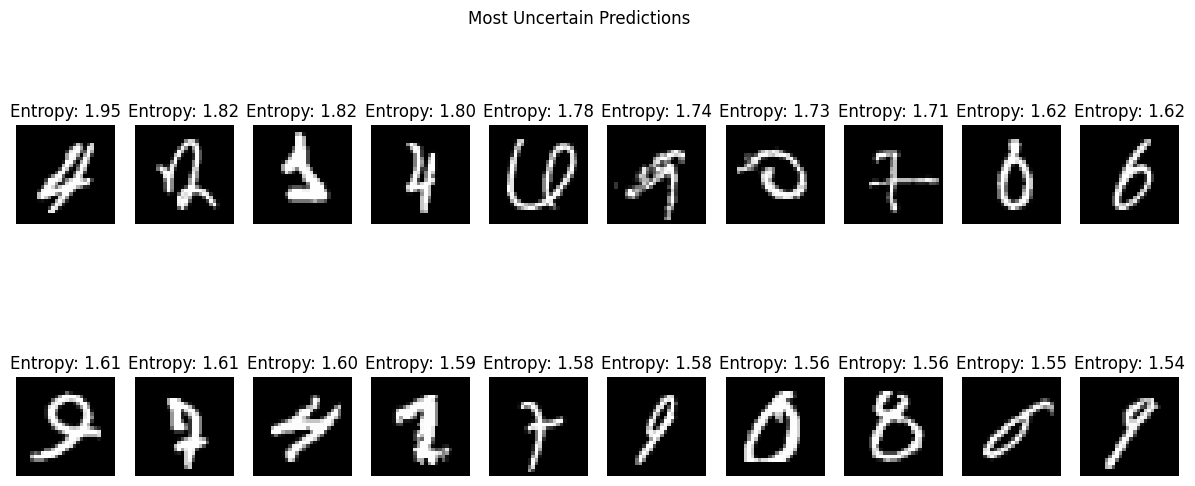

In [45]:
# Plot the most uncertain predictions
plot_most_uncertain(testset, sorted_data_indices, sorted_uncertainties, n_plot=20)

## Test new CLUE implementation

Now we test the "new" CLUE implementation, which accepts only a classifier head, directly optimising the latent code. There is no need for a decoder at each step (and therefore inside the CLUE method).
Once the latent code is optimised, we pass it through the decoder to get a reconstruction from this notebook.

### Visualising

The first test is just with one image

In [58]:
from clue import new_CLUE

# Get the most uncertain image and its latent representation
most_uncertain_idx = sorted_data_indices[3]
uncertain_image, true_label = testset[most_uncertain_idx]
uncertain_image = uncertain_image.to(device).unsqueeze(0)  # Add batch dimension

# Get its latent representation
model.eval()
with torch.no_grad():
    z0 = model.extract_features(uncertain_image)

# Initialize CLUE
clue = new_CLUE.NewCLUE(
    classifier=model,
    z0=z0,
    uncertainty_weight=1.0,
    distance_weight=.3,
    lr=0.01,
    device=device,
    bayesian=False,
    verbose=True
)

# Optimize to find explanation
z_explained = clue.optimize(steps=50)

# Generate reconstructions using decoder
with torch.no_grad():
    # Original reconstruction
    original_recon = autoencoder.decode(z0)
    # CLUE reconstruction
    clue_recon = autoencoder.decode(z_explained)

    # Get predictions and uncertainties from latent codes
    original_probs_latent = model.sample_predict_z(z0)  # [n_ensemble, batch, classes]
    explained_probs_latent = model.sample_predict_z(z_explained)

    # Get predictions from full classifier workflow on reconstructions
    original_probs_recon = model.sample_predict(original_recon)
    explained_probs_recon = model.sample_predict(clue_recon)

    # Calculate mean probabilities and entropies for latent predictions
    original_mean_probs_latent = original_probs_latent.mean(dim=0)  # [batch, classes]
    explained_mean_probs_latent = explained_probs_latent.mean(dim=0)

    original_entropy_latent = -(original_mean_probs_latent * torch.log(original_mean_probs_latent + 1e-10)).sum(dim=1)
    explained_entropy_latent = -(explained_mean_probs_latent * torch.log(explained_mean_probs_latent + 1e-10)).sum(dim=1)

    # Calculate mean probabilities and entropies for reconstruction predictions
    original_mean_probs_recon = original_probs_recon.mean(dim=0)
    explained_mean_probs_recon = explained_probs_recon.mean(dim=0)

    original_entropy_recon = -(original_mean_probs_recon * torch.log(original_mean_probs_recon + 1e-10)).sum(dim=1)
    explained_entropy_recon = -(explained_mean_probs_recon * torch.log(explained_mean_probs_recon + 1e-10)).sum(dim=1)

    # Get predicted classes
    original_pred = original_mean_probs_recon.argmax(dim=1).item()
    explained_pred = explained_mean_probs_recon.argmax(dim=1).item()

# Plot results
plt.figure(figsize=(15, 10))

plt.subplot(231)
plt.imshow(uncertain_image[0,0].cpu(), cmap='gray')
plt.title(f'Original Image\nTrue Class: {true_label}, Predicted: {original_pred}\nEntropy: {original_entropy_recon[0]:.3f}')
plt.axis('off')

plt.subplot(232)
plt.imshow(clue_recon[0,0].cpu().detach(), cmap='gray')
plt.title(f'Counterfactual\nPredicted: {explained_pred}\nEntropy: {explained_entropy_recon[0]:.3f}')
plt.axis('off')

plt.subplot(233)
diff = clue_recon[0,0].cpu().detach() - uncertain_image[0,0].cpu()
plt.imshow(diff, cmap='RdBu', vmin=-1, vmax=1)  # Fixed scale -1 to 1
plt.title('Counterfactual vs Original\nDifference\n(Red: Added Features, Blue: Removed Features)')
plt.axis('off')

plt.subplot(234)
plt.imshow(original_recon[0,0].cpu().detach(), cmap='gray')
plt.title('Original Reconstruction')
plt.axis('off')

plt.subplot(235)
recon_diff = clue_recon[0,0].cpu().detach() - original_recon[0,0].cpu().detach()
plt.imshow(recon_diff, cmap='RdBu', vmin=-1, vmax=1)  # Fixed scale -1 to 1
plt.title('Counterfactual vs Original\nReconstruction Difference\n(Red: Added Features, Blue: Removed Features)')
plt.axis('off')

plt.tight_layout()
plt.show()


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x512 and 784x704)

Step 00: Loss: 1.7110, Total Entropy: 1.7110, Updated dim: 277, Delta: 0.1000, Changes: 1/3
Step 01: Loss: 1.8371, Total Entropy: 1.7371, Updated dim: 277, Delta: -0.1000, Changes: 2/3
Step 02: Loss: 1.7420, Total Entropy: 1.7420, Updated dim: 277, Delta: 0.1000, Changes: 3/3
Step 03: Loss: 1.7871, Total Entropy: 1.6871, Updated dim: 322, Delta: 0.1000, Changes: 1/3
Step 04: Loss: 1.7673, Total Entropy: 1.6259, Updated dim: 322, Delta: -0.1000, Changes: 2/3
Step 05: Loss: 1.7656, Total Entropy: 1.6656, Updated dim: 322, Delta: 0.1000, Changes: 3/3
Step 06: Loss: 1.7815, Total Entropy: 1.6401, Updated dim: 684, Delta: 0.1000, Changes: 1/3
Step 07: Loss: 1.7174, Total Entropy: 1.5442, Updated dim: 684, Delta: -0.1000, Changes: 2/3
Step 08: Loss: 1.7867, Total Entropy: 1.6452, Updated dim: 684, Delta: 0.1000, Changes: 3/3
Step 09: Loss: 1.8651, Total Entropy: 1.6919, Updated dim: 276, Delta: 0.1000, Changes: 1/3
Step 10: Loss: 1.8000, Total Entropy: 1.6000, Updated dim: 276, Delta: -0.100

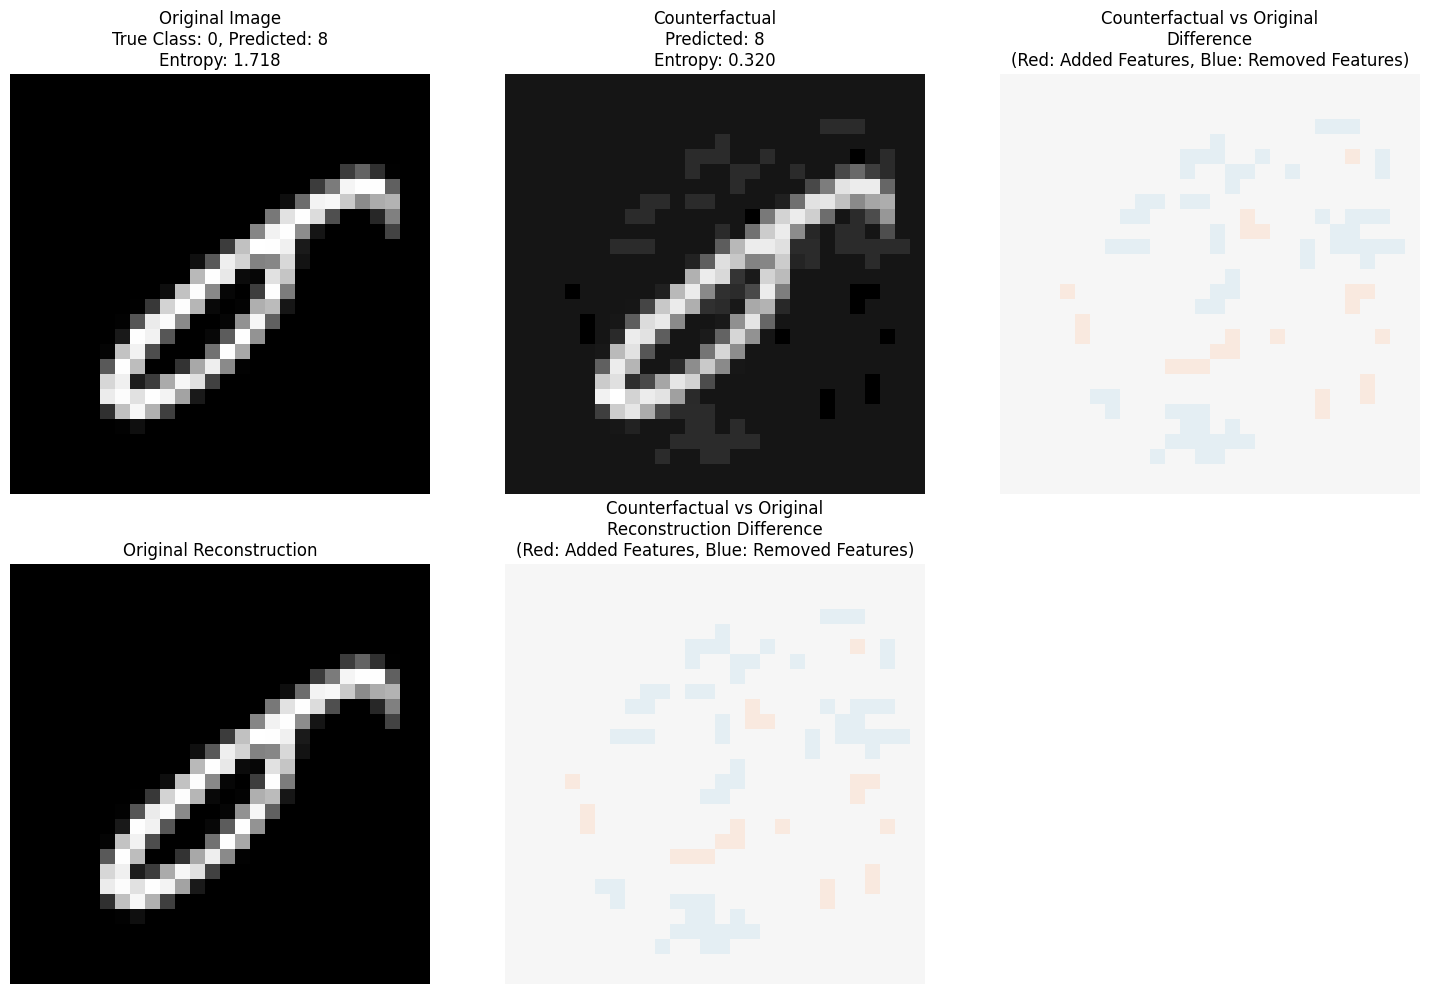

In [28]:

from clue import greedy_CLUE
importlib.reload(greedy_CLUE)

# Get the most uncertain image and its latent representation
most_uncertain_idx = sorted_data_indices[3]
uncertain_image, true_label = testset[most_uncertain_idx]
uncertain_image = uncertain_image.to(device).unsqueeze(0)  # Add batch dimension

# Get its latent representation
model.eval()
with torch.no_grad():
    z0 = model.extract_features(uncertain_image)

# Initialize CLUE
clue = greedy_CLUE.GreedyCLUE(
    classifier=model,
    z0=z0,
    device='cuda',
    bayesian = True,
    verbose = True
)

# Optimize to find explanation
z_explained = clue.optimize(steps=100)

# Generate reconstructions using decoder
with torch.no_grad():
    # Original reconstruction
    original_recon = autoencoder.decode(z0)
    # CLUE reconstruction
    clue_recon = autoencoder.decode(z_explained)

    # Get predictions and uncertainties from latent codes
    original_probs_latent = model.sample_predict_z(z0)  # [n_ensemble, batch, classes]
    explained_probs_latent = model.sample_predict_z(z_explained)

    # Get predictions from full classifier workflow on reconstructions
    original_probs_recon = model.sample_predict(original_recon)
    explained_probs_recon = model.sample_predict(clue_recon)

    # Calculate mean probabilities and entropies for latent predictions
    original_mean_probs_latent = original_probs_latent.mean(dim=0)  # [batch, classes]
    explained_mean_probs_latent = explained_probs_latent.mean(dim=0)

    original_entropy_latent = -(original_mean_probs_latent * torch.log(original_mean_probs_latent + 1e-10)).sum(dim=1)
    explained_entropy_latent = -(explained_mean_probs_latent * torch.log(explained_mean_probs_latent + 1e-10)).sum(dim=1)

    # Calculate mean probabilities and entropies for reconstruction predictions
    original_mean_probs_recon = original_probs_recon.mean(dim=0)
    explained_mean_probs_recon = explained_probs_recon.mean(dim=0)

    original_entropy_recon = -(original_mean_probs_recon * torch.log(original_mean_probs_recon + 1e-10)).sum(dim=1)
    explained_entropy_recon = -(explained_mean_probs_recon * torch.log(explained_mean_probs_recon + 1e-10)).sum(dim=1)

    # Get predicted classes
    original_pred = original_mean_probs_recon.argmax(dim=1).item()
    explained_pred = explained_mean_probs_recon.argmax(dim=1).item()

# Plot results
plt.figure(figsize=(15, 10))

plt.subplot(231)
plt.imshow(uncertain_image[0,0].cpu(), cmap='gray')
plt.title(f'Original Image\nTrue Class: {true_label}, Predicted: {original_pred}\nEntropy: {original_entropy_recon[0]:.3f}')
plt.axis('off')

plt.subplot(232)
plt.imshow(clue_recon[0,0].cpu().detach(), cmap='gray')
plt.title(f'Counterfactual\nPredicted: {explained_pred}\nEntropy: {explained_entropy_recon[0]:.3f}')
plt.axis('off')

plt.subplot(233)
diff = clue_recon[0,0].cpu().detach() - uncertain_image[0,0].cpu()
plt.imshow(diff, cmap='RdBu', vmin=-1, vmax=1)  # Fixed scale -1 to 1
plt.title('Counterfactual vs Original\nDifference\n(Red: Added Features, Blue: Removed Features)')
plt.axis('off')

plt.subplot(234)
plt.imshow(original_recon[0,0].cpu().detach(), cmap='gray')
plt.title('Original Reconstruction')
plt.axis('off')

plt.subplot(235)
recon_diff = clue_recon[0,0].cpu().detach() - original_recon[0,0].cpu().detach()
plt.imshow(recon_diff, cmap='RdBu', vmin=-1, vmax=1)  # Fixed scale -1 to 1
plt.title('Counterfactual vs Original\nReconstruction Difference\n(Red: Added Features, Blue: Removed Features)')
plt.axis('off')

plt.tight_layout()
plt.show()


# Multi-training and testing
In this section, we'll train many autoencoders and BNNs with varying hidden dimensions.

In [ ]:
import importlib
import train_multiple_BNN as train_multi
importlib.reload(train_multi)
from train_multiple_BNN import train_multiple_models

# Train multiple models with different hidden dimensions
dims = [32, 64, 128, 256, 512]
batch_size = 64
ae_epochs = 40
bnn_epochs = 30
include_raw = False  # Also train BNN on raw input
save_dir = "../model_saves/multi_test"

# Train all models
trained_models = train_multiple_models(
    dims=dims,
    batch_size=batch_size,
    ae_epochs=ae_epochs,
    bnn_epochs=bnn_epochs,
    include_raw=include_raw,
    base_save_dir=save_dir
)

print("\nTraining complete!")
print("\nTrained models:")
print("Autoencoders:", list(trained_models['autoencoders'].keys()))
print("BNN models:", list(trained_models['bnn_models'].keys()))
print("Raw BNN:", "Yes" if trained_models['raw_bnn'] is not None else "No")


Using device: cuda

Training autoencoder with hidden dimension: 32
Saved best model to ../model_saves/multi_test/autoencoders/autoencoder_dim32_best_model.pth
Epoch 1/40, Train Loss: 0.025093, Val Loss: 0.015500
Current learning rate: 1.00e-03
Saved best model to ../model_saves/multi_test/autoencoders/autoencoder_dim32_best_model.pth
Epoch 2/40, Train Loss: 0.016087, Val Loss: 0.013245
Current learning rate: 1.00e-03
Saved best model to ../model_saves/multi_test/autoencoders/autoencoder_dim32_best_model.pth
Epoch 3/40, Train Loss: 0.014557, Val Loss: 0.012303
Current learning rate: 1.00e-03
Saved best model to ../model_saves/multi_test/autoencoders/autoencoder_dim32_best_model.pth
Epoch 4/40, Train Loss: 0.013667, Val Loss: 0.011560
Current learning rate: 1.00e-03
Saved best model to ../model_saves/multi_test/autoencoders/autoencoder_dim32_best_model.pth
Epoch 5/40, Train Loss: 0.013014, Val Loss: 0.010850
Current learning rate: 1.00e-03
Saved best model to ../model_saves/multi_test/au

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

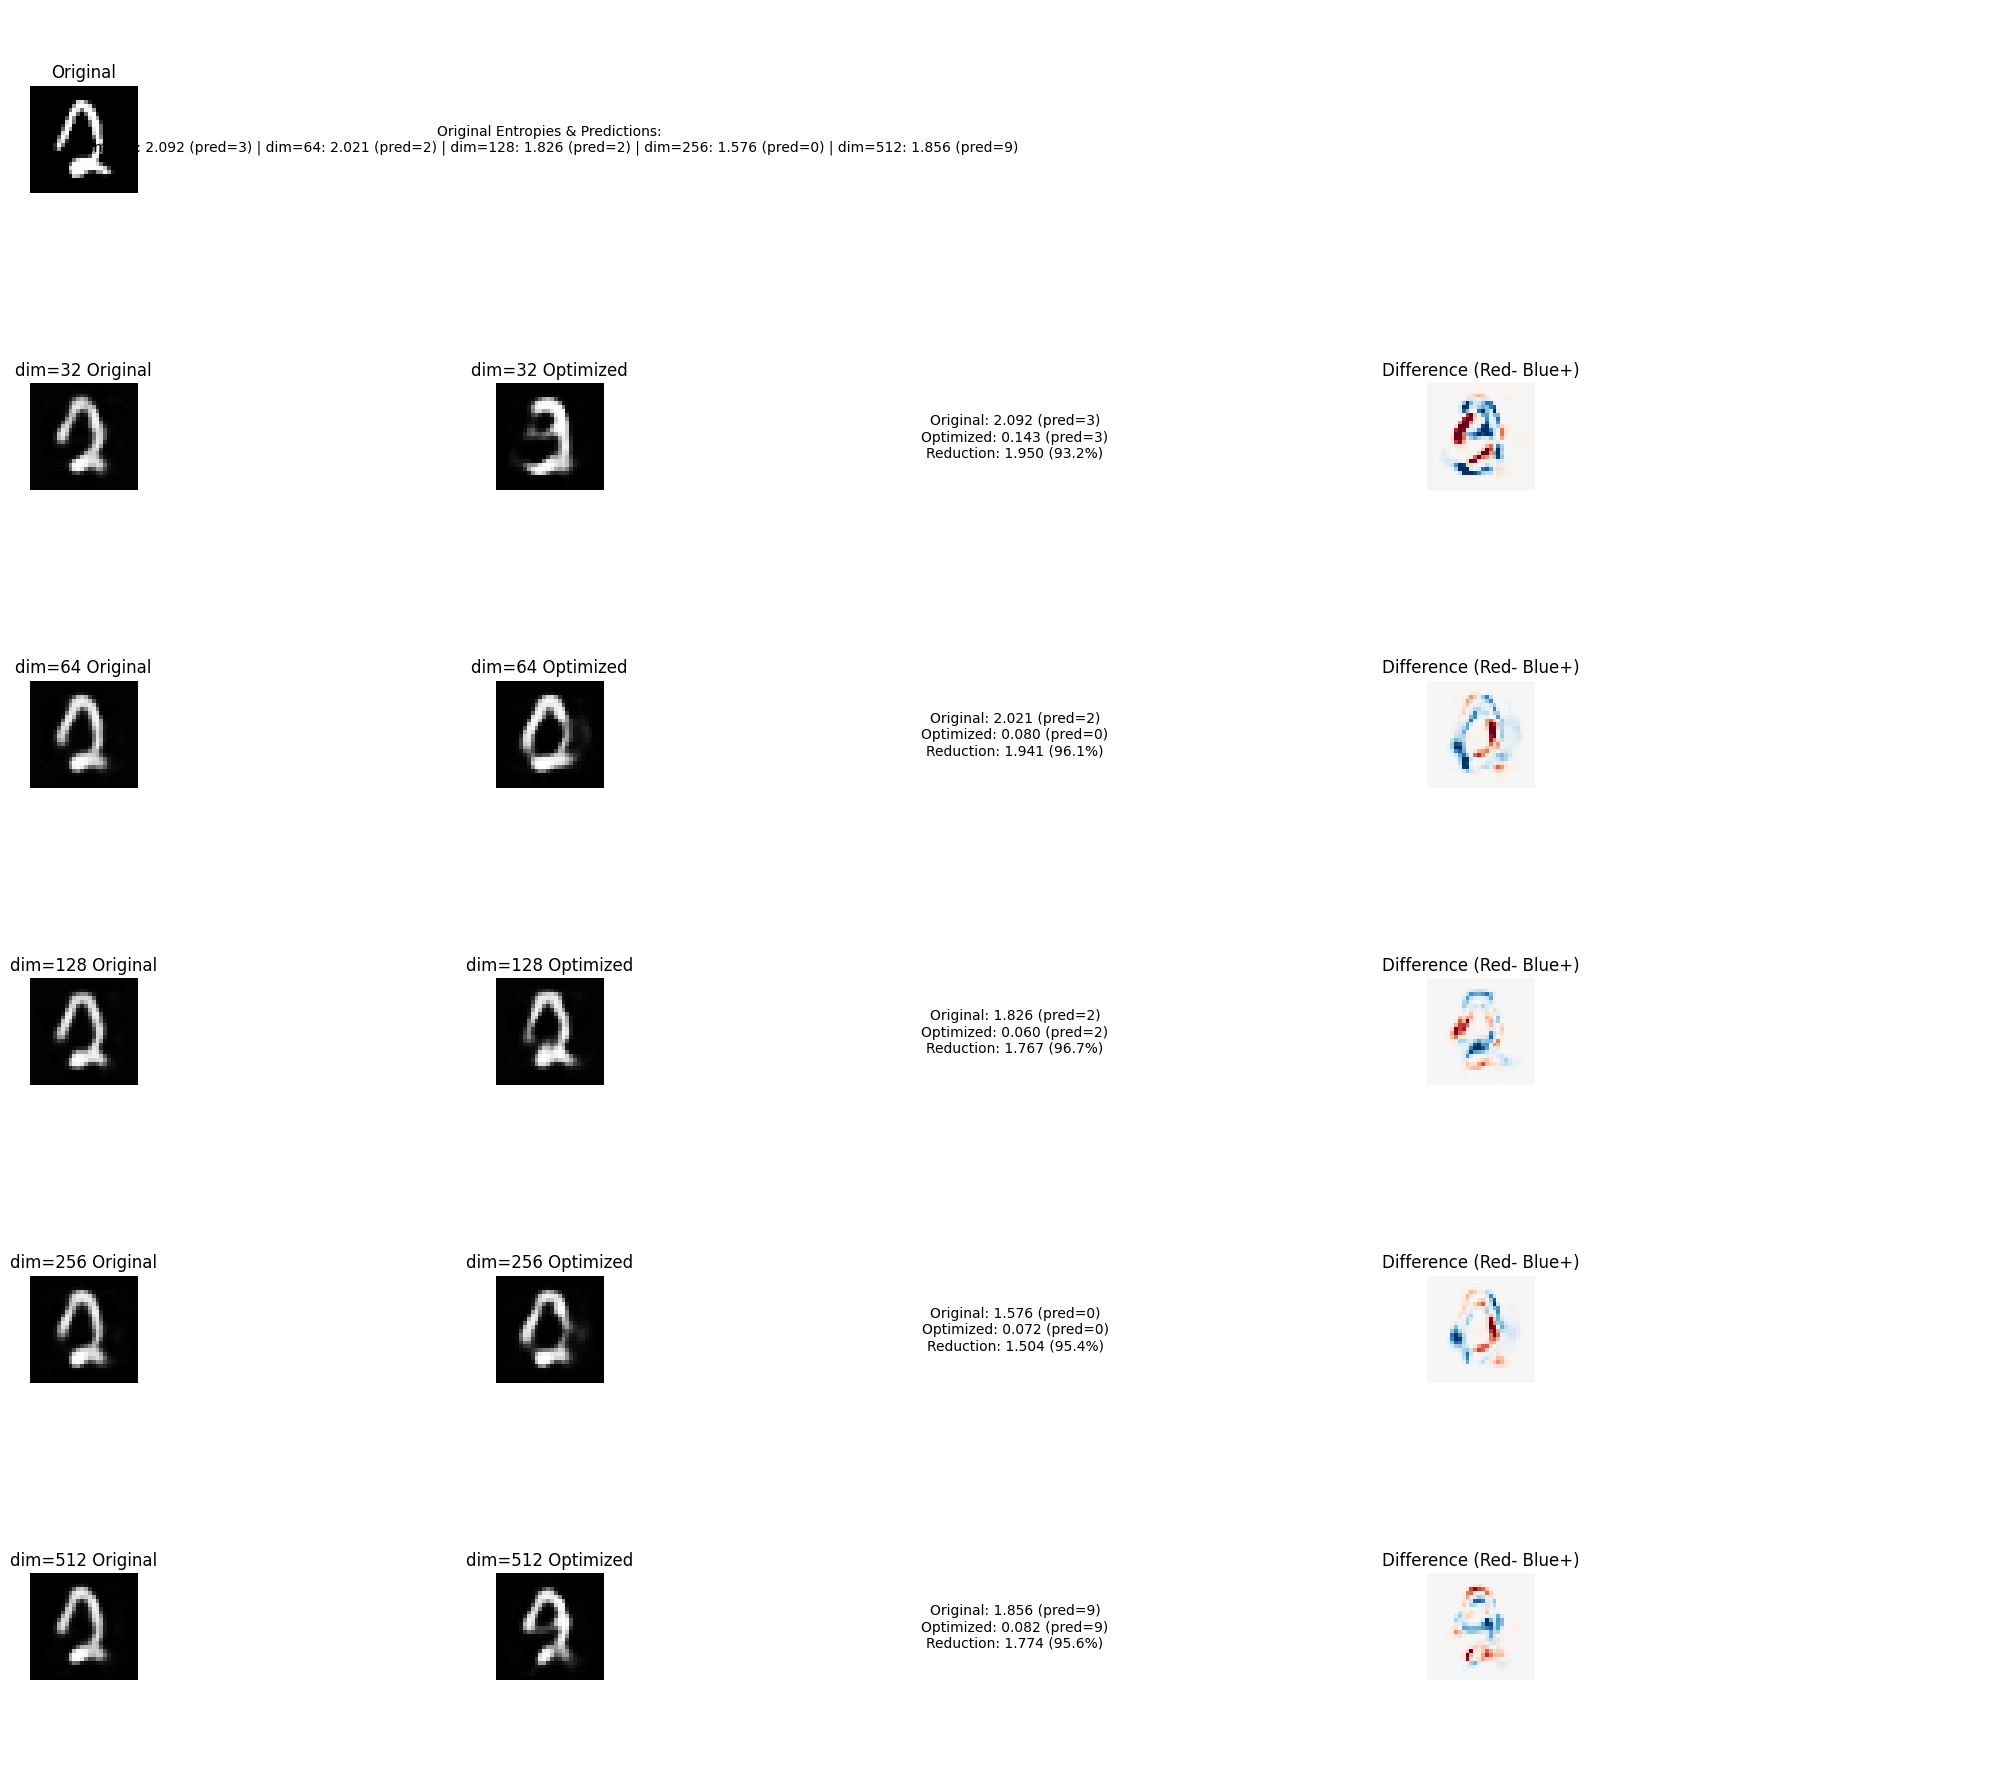

In [63]:
importlib.reload(train_multi)
from train_multiple_BNN import run_multi_model_clue

most_uncertain_idx = sorted_data_indices[6]
uncertain_image, true_label = testset[most_uncertain_idx]
uncertain_image = uncertain_image.to(device).unsqueeze(0)  # Add batch dimension

results = run_multi_model_clue(
    result = trained_models,
    input_data = uncertain_image,
    steps = 100,
    lr = 0.01,
    distance_weight = 2

)